<a href="https://colab.research.google.com/github/arthurreys/feulgen-nuclei-detection/blob/main/notebooks/Abordagem_Cl%C3%A1ssica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecção e Classificação de núcleos celulares com coloração de Feulgen, utilizando Visão Computacional Clássica

- 1. Detecção de núcleos na imagem criando bounding boxes

- 2. Classificação dos bounding boxes

- 3. Extração de métricas

- 4. Visualização de predições



In [ ]:
!pip install -q pycocotools

# Download do Dataset

In [1]:
!wget -O OD_SS.zip https://arquivos.ufsc.br/f/981acdaa6d2442f68c1a/?dl=1
!unzip OD_SS.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: OD_SS/test/OD_Labels/_b0s0c0x102400-1600y91200-1200m10096.txt  
  inflating: OD_SS/test/OD_Labels/_b0s0c0x190400-1600y73200-1200m8293.txt  
  inflating: OD_SS/test/OD_Labels/_b0s0c0x20800-1600y153600-1200m16781.txt  
  inflating: OD_SS/test/OD_Labels/_b0s0c0x208000-1600y58800-1200m6598.txt  
  inflating: OD_SS/test/OD_Labels/_b0s0c0x80000-1600y103200-1200m11402.txt  
  inflating: OD_SS/test/OD_Labels/_b0s0c0x118400-1600y14400-1200m1646.txt  
  inflating: OD_SS/test/OD_Labels/_b0s0c0x136000-1600y68400-1200m7552.txt  
  inflating: OD_SS/test/OD_Labels/_b0s0c0x4800-1600y64800-1200m7239.txt  
  inflating: OD_SS/test/OD_Labels/_b0s0c0x193600-1600y99600-1200m10994.txt  
  inflating: OD_SS/test/OD_Labels/2019_07_16__09_06__0001_b0s0c0x63572-1600y32291-1200m4394.txt  
  inflating: OD_SS/test/OD_Labels/_b0s0c0x150400-1600y85200-1200m9395.txt  
  inflating: OD_SS/test/OD_Labels/_b0s0c0x196800-1600y133200-1200m14775.txt  
  i

In [16]:
import os
import csv
import json

import cv2
from google.colab.patches import cv2_imshow
from PIL import Image

import numpy as np
import pandas as pd
from tqdm import tqdm

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.preprocessing import PolynomialFeatures

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

In [17]:
CATEGORIES_DICT = {
    'alterada':0,
    "intermediaria":1,
    "velhas":2,
    "sujeira":3,
    "sobreposicao":4,
    "nao_identificado":5,
    "neutrofilo":6,
    "mancha":7,
}

train_path = "/content/OD_SS/train/Images"
img_paths = os.listdir(train_path)
paths = [f"{train_path}/{path}" for path in img_paths]

# 1. Binarização e obtenção de bounding boxes

In [18]:
def detect_cells_by_color(
    image,
    lower_bound = np.array([90, 50, 10]),
    upper_bound = np.array([170, 255, 255]),
    color_transform = cv2.COLOR_BGR2HSV,
    morph_kernel = np.ones((5, 5), np.uint8)
):

    # Conversão de espaço de cor
    if color_transform is not None:
      transformed_image = cv2.cvtColor(image, color_transform)
    else:
      transformed_image = image

    # Aplica limiar de cor
    color_mask = cv2.inRange(transformed_image, lower_bound, upper_bound)

    if morph_kernel is not None:
      # Aplica morfologia
      color_mask = cv2.morphologyEx(color_mask, cv2.MORPH_OPEN, morph_kernel)
      color_mask = cv2.morphologyEx(color_mask, cv2.MORPH_CLOSE, morph_kernel)

    return color_mask

In [19]:
def draw_bounding_boxes(image, mask, min_area=200):
    # Delimita contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filtra com base em área mínima
    filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]

    # Desenha os bounding boxes
    bounding_boxes_image = image.copy()
    bounding_boxes = []
    for cnt in filtered_contours:
        x, y, w, h = cv2.boundingRect(cnt)
        bounding_boxes.append([x, y, w, h])
        cv2.rectangle(bounding_boxes_image, (x, y), (x + w, y + h), (0, 0, 255), 2, )

    return bounding_boxes_image, bounding_boxes

In [20]:
def make_plot_mask_bbox(img, color_mask, bounding_boxes_image, ground_truth = None, save_dir=None):
  # Display da pipeline de detecção

  cols = 3
  if ground_truth is not None:
    cols +=1

  plt.figure(figsize=(20, 5))
  plt.subplot(1, cols, 1)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.title('Imagem original')
  plt.axis('off')

  plt.subplot(1, cols, 2)
  plt.imshow(cv2.cvtColor(color_mask, cv2.COLOR_BGR2RGB))
  plt.title('Máscara processada')
  plt.axis('off')

  plt.subplot(1, cols, 3)
  plt.imshow(cv2.cvtColor(bounding_boxes_image, cv2.COLOR_BGR2RGB))
  plt.title('Bounding Boxes')
  plt.axis('off')

  plt.subplot(1, cols, 3)
  plt.imshow(cv2.cvtColor(bounding_boxes_image, cv2.COLOR_BGR2RGB))
  plt.title('Bounding Boxes')
  plt.axis('off')

  if ground_truth is not None:
    plt.subplot(1, cols, 4)
    plt.imshow(ground_truth)
    plt.title('Ground Truth')
    plt.axis('off')

  if save_dir:
    plt.savefig(save_dir)

  plt.show()



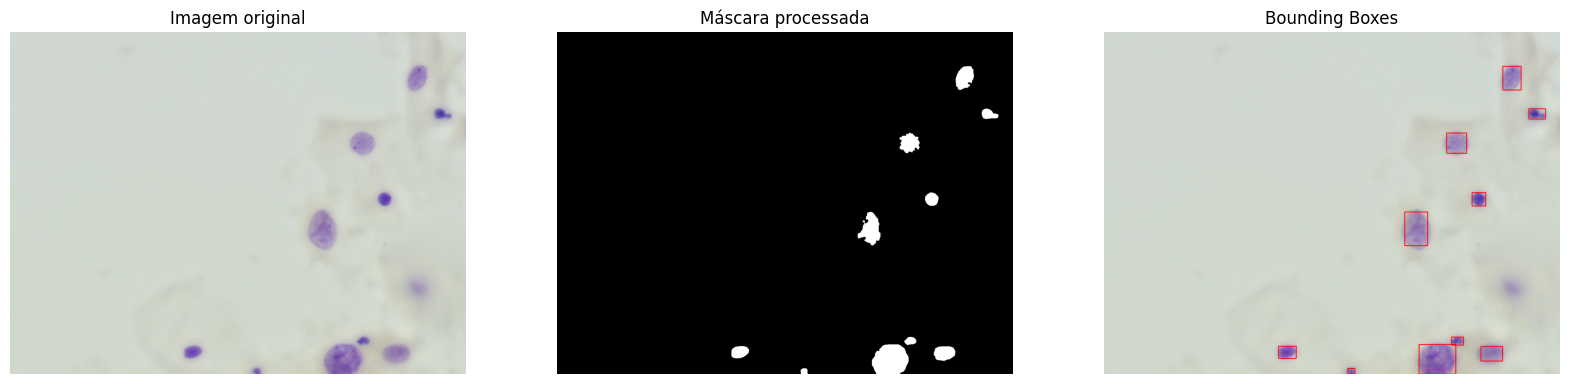

In [21]:
# Pipeline em imagem de exemplo
img = cv2.imread(paths[190])

color_mask = detect_cells_by_color(img)

bounding_boxes_image, _ = draw_bounding_boxes(img, color_mask)

make_plot_mask_bbox(img, color_mask, bounding_boxes_image)

In [22]:
def predict_boxes_for_image(image_path):
  # Aplica pipeline de detecção de bounding boxes

  img = cv2.imread(image_path)
  color_mask = detect_cells_by_color(img)
  _, bounding_boxes = draw_bounding_boxes(img, color_mask)

  return bounding_boxes

# 2. Modelo de Classificação de bounding boxes


### Criação da Feature Matrix

In [23]:
def compute_features(box_image):
  # Computa features a partir de um bounding box

  w = box_image.shape[0]
  h = box_image.shape[1]
  # Área removida pois será uma feature com polynomialfeatures
  # area = w*h

  avg = np.mean(box_image)

  avg_0 = np.mean(box_image[0])
  avg_1 = np.mean(box_image[1])
  avg_2 = np.mean(box_image[2])

  max_0 = np.max(box_image[0])
  max_1 = np.max(box_image[1])
  max_2 = np.max(box_image[2])

  min_0 = np.min(box_image[0])
  min_1 = np.min(box_image[1])
  min_2 = np.min(box_image[2])

  std_0 = np.std(box_image[0])
  std_1 = np.std(box_image[1])
  std_2 = np.std(box_image[2])

  return [
    w,
    h,

    avg,

    avg_0,
    avg_1,
    avg_2,

    max_0,
    max_1,
    max_2,

    min_0,
    min_1,
    min_2,

    std_0,
    std_1,
    std_2,
  ]

In [24]:
def read_image_boxes(image_path):

  with open(image_path.replace('Images', 'OD_Labels').replace('.png', '.txt')) as csv_file:
      csv_reader = csv.reader(csv_file, delimiter=',')

      boxes = []

      for bbox in csv_reader:
          x, y, w, h, label = int(bbox[0].strip()), int(bbox[1].strip()), int(bbox[2].strip()), int(bbox[3].strip()), bbox[4].strip()
          boxes.append([x, y, w, h, label])

  return boxes

def get_box_features(img, box, includes_label=False):

  if includes_label:
    x, y, w, h, label = box
  else:
    x, y, w, h= box
    label=None


  box_image = img[y:y+h, x:x+w, :]

  features = compute_features(box_image)

  return features

def get_boxes_features(image_path):

  boxes = read_image_boxes(image_path)
  img = cv2.imread(image_path)

  box_features = []

  for box in boxes:

    x, y, w, h, label = box

    box_image = img[y:y+h, x:x+w, :]

    if box_image.any():

      features = compute_features(box_image)

      box_features.append(features + [label])

  return box_features

In [25]:
def show_boxes(image_path):

  boxes = read_image_boxes(image_path)
  img = cv2.imread(image_path)

  for box in boxes:
    x, y, w, h, label = box
    print(label)
    cv2_imshow(img[y:y+h, x:x+w, :])

In [26]:
def make_feature_matrix(img_path):
  image_paths = [f"{img_path}{filename}" for filename in os.listdir(img_path)]

  features = []
  for img_path in tqdm(image_paths):
    features.extend(get_boxes_features(img_path))

  df = pd.DataFrame(features).dropna()

  df.rename(columns={df.shape[1]-1:'label'}, inplace=True)

  return df.drop(columns='label').values, df['label']

In [27]:
x_train, y_train = make_feature_matrix("OD_SS/train/Images/")

100%|██████████| 1565/1565 [01:05<00:00, 23.81it/s]


In [28]:
x_test, y_test = make_feature_matrix("OD_SS/test/Images/")

100%|██████████| 195/195 [00:08<00:00, 22.61it/s]


### Treinamento do modelo

In [29]:
model = Pipeline(
    [
        ('polynom', PolynomialFeatures(2)),
        ('preprocessing', StandardScaler()),
        # ('model', LogisticRegression(class_weight='balanced', max_iter=1000))
        # ('model', SGDClassifier(class_weight='balanced', max_iter=1000))
        ('model', LogisticRegressionCV(class_weight='balanced', max_iter=1000))
    ]
)

model.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Pipeline(steps=[('polynom', PolynomialFeatures()),
                ('preprocessing', StandardScaler()),
                ('model',
                 LogisticRegressionCV(class_weight='balanced', max_iter=1000))])

In [30]:
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

In [31]:
# Métricas de treino
print(classification_report(
    y_train,
    y_pred_train,
    labels = model['model'].classes_
))

                  precision    recall  f1-score   support

        alterada       0.42      0.34      0.38      2258
   intermediaria       0.72      0.76      0.74      5279
          mancha       0.54      0.58      0.56      1102
nao_identificado       0.72      0.59      0.65      5057
      neutrofilo       0.54      0.55      0.54      3959
    sobreposicao       0.50      0.46      0.48      1642
         sujeira       0.33      0.53      0.41       521
          velhas       0.40      0.50      0.45      2357

        accuracy                           0.58     22175
       macro avg       0.52      0.54      0.53     22175
    weighted avg       0.59      0.58      0.58     22175



In [32]:
# Métricas de teste
print(classification_report(
    y_test,
    y_pred_test,
    labels = model['model'].classes_
))

                  precision    recall  f1-score   support

        alterada       0.35      0.32      0.34       222
   intermediaria       0.69      0.75      0.72       623
          mancha       0.53      0.50      0.51       126
nao_identificado       0.74      0.60      0.66       614
      neutrofilo       0.51      0.53      0.52       413
    sobreposicao       0.52      0.44      0.48       195
         sujeira       0.46      0.64      0.54        75
          velhas       0.41      0.51      0.45       269

        accuracy                           0.58      2537
       macro avg       0.53      0.54      0.53      2537
    weighted avg       0.59      0.58      0.58      2537



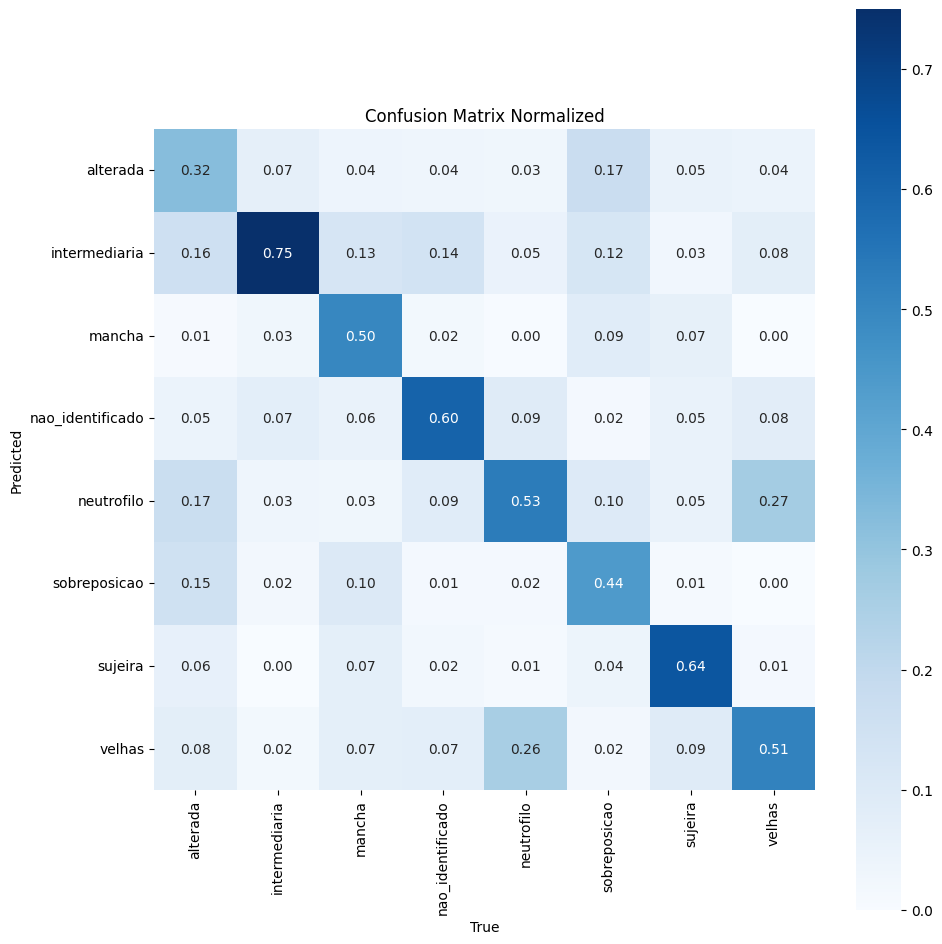

In [33]:
cm = confusion_matrix(y_test, y_pred_test, labels=model.classes_)

fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(
    (cm/cm.sum(axis=1).reshape(-1,1)).T,
    square=True,
    yticklabels=model.classes_,
    xticklabels=model.classes_,
    cmap="Blues",
    annot = (cm/cm.sum(axis=1).reshape(-1,1)).T,
    fmt=".2f",
    annot_kws={"size": 10}
)

ax.set_xlabel("True")
ax.set_ylabel('Predicted')

ax.set_title('Confusion Matrix Normalized')

plt.tight_layout()

plt.savefig('matriz_confusao_classico.png')

plt.show()

# 3. Obtenção de métricas utilizando pycocotools, para comparação com abordagem de rede neural

In [34]:
!pip install pycocotools

In [35]:
def convert_to_coco_format(image_dir, label_dir, output_file):
  # Conversão de labels para formato COCO
  coco_data = {
      "info": {},
      "licenses": [],
      "images": [],
      "annotations": [],
      "categories": []
  }

  categories = [{
      "id": value,
      "name": key,
      "supercategory": "none",

  } for key, value in CATEGORIES_DICT.items()
  ]

  coco_data["categories"] = categories

  # Cria ids
  image_ids = 1
  annotation_id = 1

  for filename in os.listdir(image_dir):
      if filename.endswith(".png"):
          image_path = os.path.join(image_dir, filename)
          label_path = os.path.join(label_dir, filename.replace(".png", ".txt"))

          with Image.open(image_path) as img:
              width, height = img.size

          coco_data["images"].append({
              "id": image_ids,
              "file_name": filename,
              "width": width,
              "height": height,
          })

          # Lê bounding boxes
          with open(label_path, 'r') as label_file:
              csv_reader = csv.reader(label_file, delimiter=',')
              for bbox in csv_reader:

                  x, y, w, h, label = int(bbox[0].strip()), int(bbox[1].strip()), int(bbox[2].strip()), int(bbox[3].strip()), bbox[4].strip()

                  # Cria anotação por Bbox
                  coco_data["annotations"].append({
                      "id": annotation_id,
                      "image_id": image_ids,
                      "category_id": CATEGORIES_DICT[label],
                      "bbox": [x, y, w, h],
                      "area": w * h,
                      "iscrowd": 0,
                  })

                  annotation_id += 1

          image_ids += 1

  # Save the COCO format data to a JSON file
  with open(output_file, 'w') as json_file:
      json.dump(coco_data, json_file)


def get_coco_image_ids(coco_json_path):
  with open(coco_json_path, 'r') as file:
    coco_json = json.load(file)

  ids = [item['id'] for item in coco_json['images']]
  filenames = [item['file_name'] for item in coco_json['images']]

  return pd.DataFrame({'id': ids, 'filename':filenames})


def convert_to_coco_predictions(dataframe, output_file):
  # Initialize COCO format dictionary
  annotations = []

  for index, row in tqdm(dataframe.iterrows(), total=dataframe.shape[0]):
      annotations.append({
          "image_id": row["id"],
          "filename": row["filename"],
          "category_id": CATEGORIES_DICT[row['pred_label']] ,  # Assuming there is only one category
          "bbox": row["pred_boxes"],
          "score": row["confidence"],  # Confidence score
      })

  with open(output_file, 'w') as json_file:
      json.dump(annotations, json_file)



In [36]:
# Obter Labels no formato COCO
convert_to_coco_format("/content/OD_SS/train/Images/", "/content/OD_SS/train/OD_Labels/", "train_coco.json")
convert_to_coco_format("/content/OD_SS/val/Images/", "/content/OD_SS/val/OD_Labels/", "val_coco.json")
convert_to_coco_format("/content/OD_SS/test/Images/", "/content/OD_SS/test/OD_Labels/", "test_coco.json")

In [37]:
evaluation_path = "/content/OD_SS/test/"
coco_json_path = 'test_coco.json'

In [38]:
df_ids = get_coco_image_ids(coco_json_path)
df_ids.head()

,id,filename
0,1,_b0s0c0x188800-1600y3600-1200m520.png
1,2,_b0s0c0x182400-1600y33600-1200m3810.png
2,3,_b0s0c0x14400-1600y28800-1200m3153.png
3,4,_b0s0c0x97600-1600y30000-1200m3336.png
4,5,_b0s0c0x3200-1600y39600-1200m4325.png


In [39]:
# Boxes para cada imagem

In [40]:
boxes_dict = []

for idx, row in tqdm(df_ids.iterrows(), total = df_ids.shape[0]):

  img_path = os.path.join(evaluation_path,'Images', row['filename'])

  img = cv2.imread(img_path)

  boxes = predict_boxes_for_image(img_path)

  box_features = []

  for box in boxes:
    x,y,w,h = box
    img_box = img[y:y+h, x:x+w, :]
    box_features.append(compute_features(img_box))

  boxes_dict.append(
      {
          'id': row['id'],
          'filename': row['filename'],
          'full_path': img_path,
          'pred_boxes': boxes,
          'features': box_features
      }
  )


100%|██████████| 195/195 [00:25<00:00,  7.70it/s]


In [41]:
df_x_test = pd.DataFrame(boxes_dict)

df_exploded_boxes = pd.DataFrame(boxes_dict)['pred_boxes'].explode()

df_exploded_features = pd.DataFrame(boxes_dict)['features'].explode()

df_x_test = (
    df_x_test.drop(columns=['pred_boxes', 'features'])
    .join(df_exploded_boxes)
    .assign(features = lambda df: df_exploded_features.values)
    .dropna(subset='pred_boxes')
)

df_x_test['pred_label'] = model.predict(np.array(df_x_test.features.tolist()))
df_x_test['confidence'] = model.predict_proba(np.array(df_x_test.features.tolist())).max(axis=1)

df_x_test.head()

,id,filename,full_path,pred_boxes,features,pred_label,confidence
0,1,_b0s0c0x188800-1600y3600-1200m520.png,/content/OD_SS/test/Images/_b0s0c0x188800-1600...,"[560, 1105, 144, 95]","[95, 144, 123.08728070175438, 133.780092592592...",mancha,0.353836
0,1,_b0s0c0x188800-1600y3600-1200m520.png,/content/OD_SS/test/Images/_b0s0c0x188800-1600...,"[495, 938, 62, 96]","[96, 62, 119.87528001792114, 151.9247311827957...",alterada,0.418272
0,1,_b0s0c0x188800-1600y3600-1200m520.png,/content/OD_SS/test/Images/_b0s0c0x188800-1600...,"[174, 815, 116, 79]","[79, 116, 144.06841990397206, 176.859195402298...",sobreposicao,0.559291
0,1,_b0s0c0x188800-1600y3600-1200m520.png,/content/OD_SS/test/Images/_b0s0c0x188800-1600...,"[349, 776, 76, 127]","[127, 76, 144.2512778008012, 161.8640350877193...",sobreposicao,0.511233
1,2,_b0s0c0x182400-1600y33600-1200m3810.png,/content/OD_SS/test/Images/_b0s0c0x182400-1600...,"[1263, 1063, 48, 44]","[44, 48, 167.2247474747475, 172.70138888888889...",nao_identificado,0.867943


In [42]:
# Converte predições do modelo para formatoo COCO
convert_to_coco_predictions(df_x_test, "output_coco_predictions.json")

100%|██████████| 2489/2489 [00:00<00:00, 17841.27it/s]


In [43]:
# Métricas de teste via COCOeval

gt_coco = COCO(coco_json_path)
pred_coco = gt_coco.loadRes('output_coco_predictions.json')

coco_eval = COCOeval(gt_coco, pred_coco, 'bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.44s).
Accumulating evaluation results...
DONE (t=0.09s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.122
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.181
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.142
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.122
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.083
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.096
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.224
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

# Visualização de Predições

In [44]:
def get_true_boxes(image_name):
  labels_path = f'OD_SS/test/OD_Labels/{image_name}.txt'


  with open(labels_path) as csv_file:
      csv_reader = csv.reader(csv_file, delimiter=',')

      boxes = []

      for bbox in csv_reader:
          x, y, w, h, label = int(bbox[0].strip()), int(bbox[1].strip()), int(bbox[2].strip()), int(bbox[3].strip()), bbox[4].strip()

          if label == "alterada":
              category_id = 0
          elif label == "intermediaria":
              category_id = 1
          elif label == "velhas":
              category_id = 2
          elif label == "sujeira":
              category_id = 3
          elif label == "sobreposicao":
              category_id = 4
          elif label == "nao_identificado":
              category_id = 5
          elif label == "neutrofilo":
              category_id = 6
          elif label == "mancha":
              category_id = 7

          boxes.append({
              'image_id': image_name,
              'category_id': category_id,
              'bbox': [x, y, w, h],
              'score': None
          })
  return boxes

In [45]:
def plot_image_with_boxes(image_path, boxes, category_map, normalized=True, plot=True):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Adiciona bboxes
    for box in boxes:
        x, y, w, h = box['bbox']
        category_id = int(box['category_id'])
        score = box['score']

        # Conversão de coordenadas
        img_width = 1
        img_height = 1
        if normalized:
          img_width, img_height = image.shape[1], image.shape[0]

        x = int(x * img_width)
        y = int(y * img_height)
        w = int(w * img_width)
        h = int(h * img_height)

        if normalized:
          x_start = int(x - w/2)
          y_start = int(y - h/2)
          x_end = int(x + w/2)
          y_end = int(y + h/2)
        else:
          x_start = int(x)
          y_start = int(y)
          x_end = int(x + w)
          y_end = int(y + h)

        # Desenha bbox
        thickness = 2
        colors = [
            (255, 0, 0),
            (0, 255, 0),
            (0, 0, 255),
            (128, 128, 0),
            (128, 0, 128),
            (0, 128, 128),
            (128, 128,128),
            (255, 0, 255)
        ]

        cv2.rectangle(image_rgb, (x_start, y_start), (x_end, y_end), colors[category_id], thickness)

        if score:
          label = f'{category_map[category_id]} ({score:.2f})'
        else:
          label = f'{category_map[category_id]}'
        cv2.putText(image_rgb, label, (x_start, y_start - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, colors[category_id], thickness)

    # Display
    if plot:
      plt.imshow(image_rgb)
      plt.axis('off')
      plt.show()
    else:
      return image_rgb

In [46]:
example_test_images = [
    '_b0s0c0x49600-1600y63600-1200m7027',
    '_b0s0c0x123200-1600y124800-1200m13701',
    '_b0s0c0x8000-1600y62400-1200m6817',
    '_b0s0c0x62400-1600y43200-1200m4755',
]

In [47]:
predictions_path = "output_coco_predictions.json"

with open(predictions_path, 'r') as file:
  predictions = json.load(file)

In [48]:
labels_map = {
    0: "alterada",
    1: "intermediaria",
    2: "velhas",
    3: "sujeira",
    4: "sobreposicao",
    5: "nao_identificado",
    6: "neutrofilo",
    7: "mancha",
}

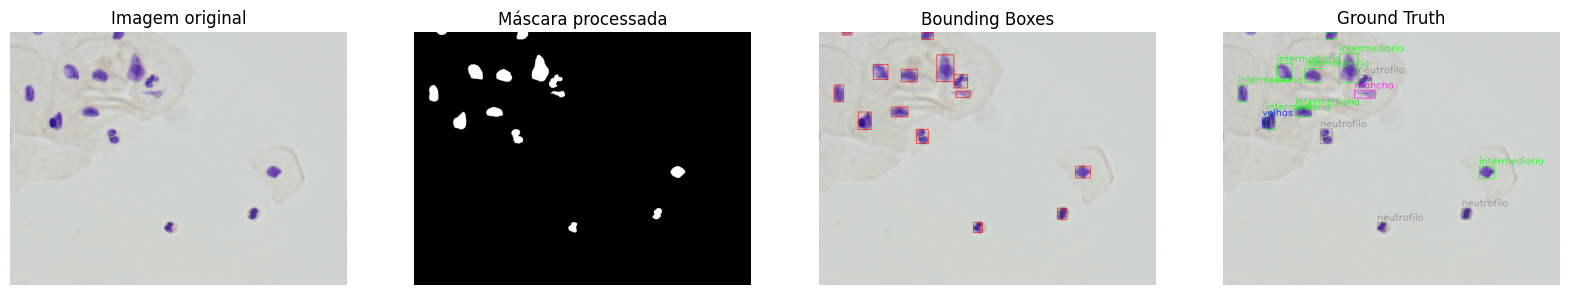

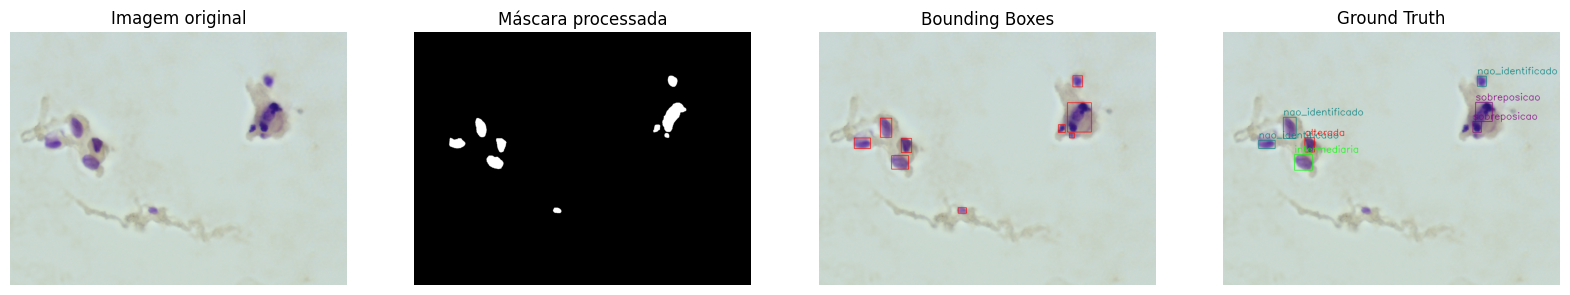

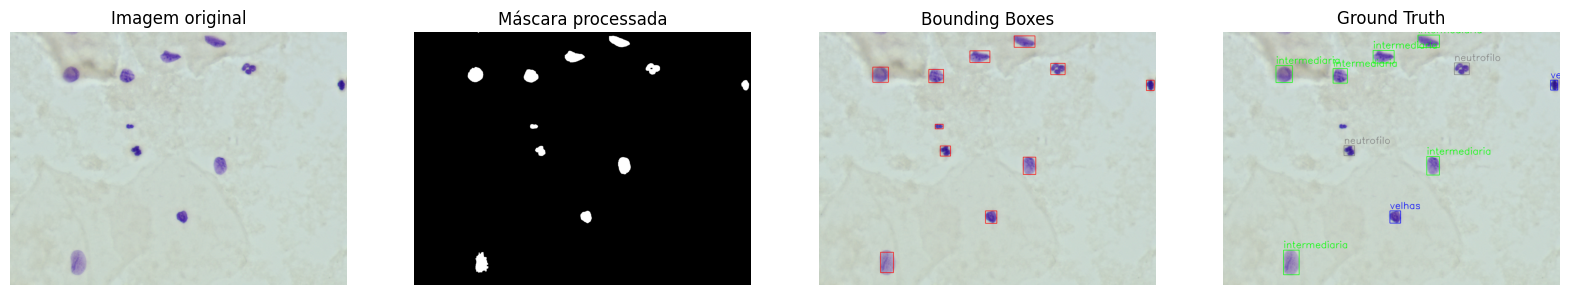

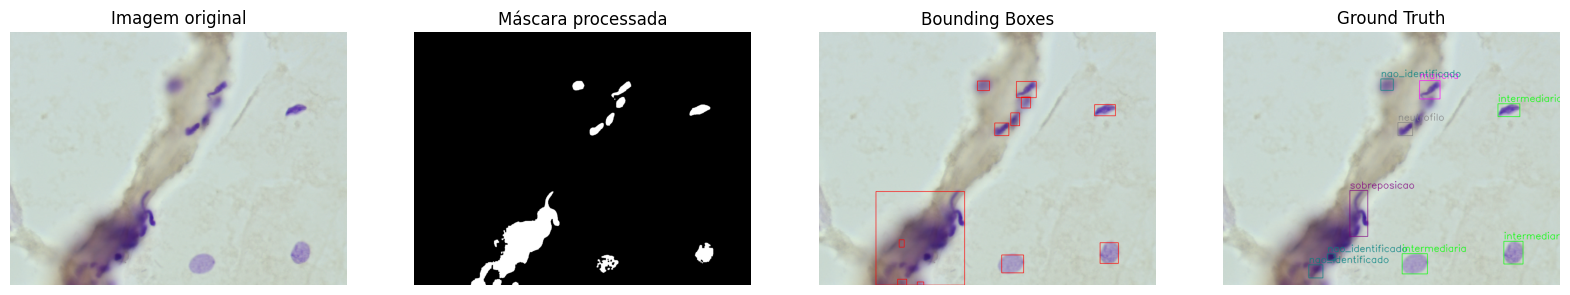

In [49]:
for image_name in example_test_images:
  full_path = f'OD_SS/test/Images/{image_name}.png'
  labels_path = f'OD_SS/test/OD_Labels/{image_name}.txt'

  true_boxes = get_true_boxes(image_name)

  ground_truth = plot_image_with_boxes(full_path, true_boxes, labels_map, normalized=False, plot=False)

  img = cv2.imread(full_path)

  color_mask = detect_cells_by_color(img)

  bounding_boxes_image, _ = draw_bounding_boxes(img, color_mask)

  make_plot_mask_bbox(img, color_mask, bounding_boxes_image, ground_truth = ground_truth,  save_dir = f"{image_name}_pred.png")

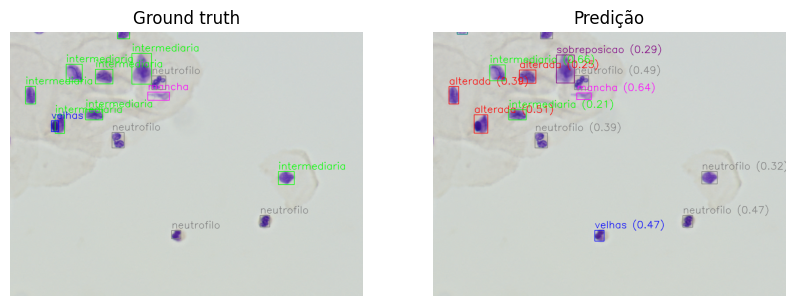

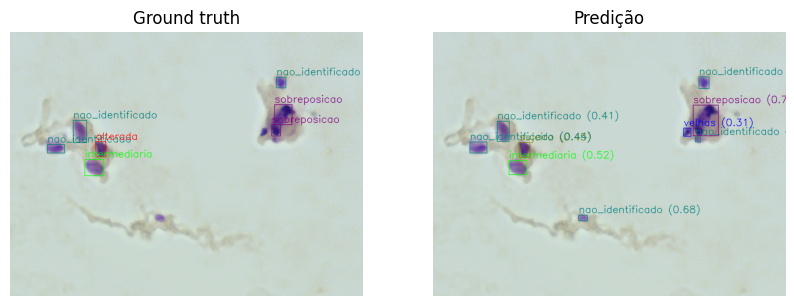

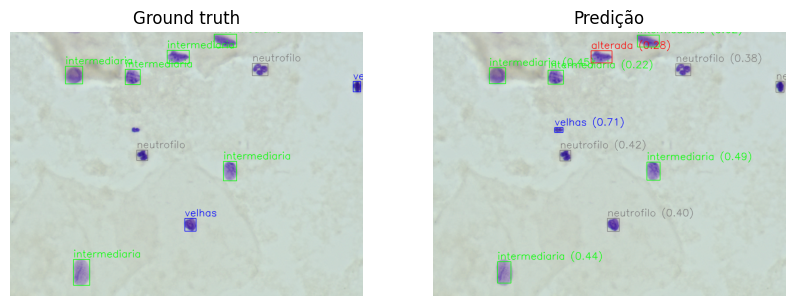

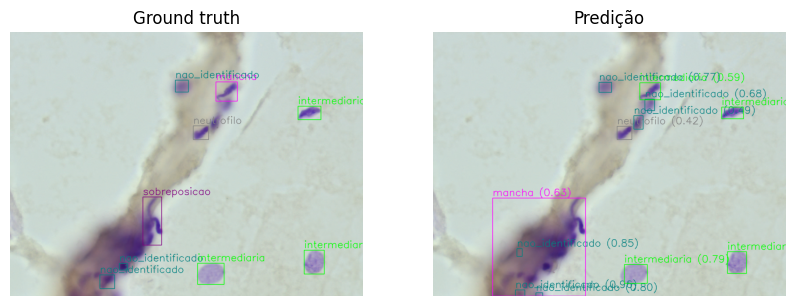

In [50]:
for image_name in example_test_images:
  full_path = f'OD_SS/test/Images/{image_name}.png'
  labels_path = f'OD_SS/test/OD_Labels/{image_name}.txt'

  pred_boxes = [item for item in predictions if item['filename'] == image_name+'.png' and item['score'] > 0]

  true_boxes = get_true_boxes(image_name)

  true_img = plot_image_with_boxes(full_path, true_boxes, labels_map, normalized=False, plot=False)
  pred_img = plot_image_with_boxes(full_path, pred_boxes, labels_map, normalized=False, plot=False)

  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.imshow(true_img)
  plt.title('Ground truth')
  plt.axis('off')

  plt.subplot(1, 2, 2)
  plt.imshow(pred_img)
  plt.title('Predição')
  plt.axis('off')

  plt.savefig(f'{image_name}_pipeline_pred.png', bbox_inches='tight')
  plt.show()
